In [1]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from scipy.fftpack import * 

## 2D DCT get 1D spectrum
按照Denis 2002的方法进行2D dct的谱合并，制作1D谱分析

## 数据读入

In [2]:
ke_sum = {}
dir_out = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/ke_daily_vi/"
ds_ke_sum = xr.open_dataset(dir_out + "ke_all_400-100_hPa_vi.nc")
ke_sum['rcm'] = ds_ke_sum['vertical integration Ke']

dir_out = "/raid52/yycheng/MPAS/VR_postprocess/VR_merge/ke_daily_vi/"
ds_ke_sum = xr.open_dataset(dir_out + "ke_all_400-100_hPa_vi.nc")
ke_sum['vr'] = ds_ke_sum['vertical integration Ke']

# 通过外插，去除掉边界上因RCM范围选取问题产生的nan的点
var_rmnan = {}
var_rmnan['vr'] = ke_sum['vr'].interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")
var_rmnan['rcm'] = ke_sum['rcm'].interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")

In [3]:
# 选取数据范围
sel_dict = {}
month_sel_vr  = var_rmnan['vr'].Time.dt.month.isin([6,7,8])
month_sel_rcm = var_rmnan['rcm'].Time.dt.month.isin([6,7,8])

lat = var_rmnan['vr'].latitude
lon = var_rmnan['vr'].longitude
sel_dict['latitude'] = lat[(lat>=20) & (lat<=50)]
sel_dict['longitude'] = lon[(lon>=100) & (lon<=140)]

var_sel = {}
sel_dict['Time'] = month_sel_vr
var_sel['vr']  = var_rmnan['vr'].loc[sel_dict]
sel_dict['Time'] = month_sel_rcm
var_sel['rcm'] = var_rmnan['rcm'].loc[sel_dict]

## DCTN

In [4]:
# 2D fft
# ke_vi_sum # Time x lat x lon : 3080 x 160 x 280
dctn_3d = {}
dctn_3d['vr'] = dctn(var_sel['vr'].values, type = 2, axes = [1,2])
dctn_3d['rcm'] = dctn(var_sel['rcm'].values, type = 2, axes = [1,2])

# 添加维度参数
ntime = dctn_3d['vr'].shape[0]
nlat  = dctn_3d['vr'].shape[1]
nlon  = dctn_3d['vr'].shape[2]
# 添加频谱参数


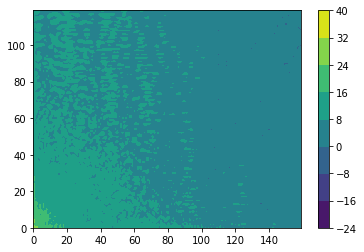

In [5]:
# 简单检查2D谱 (绘制方差)
plt.contourf(np.log(np.abs(dctn_3d['vr'][:,:].mean(axis=0)**2)))
plt.colorbar()

## 从2D谱方位角求和获得1D谱

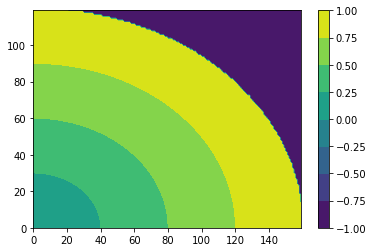

In [6]:
# 仿照denis2002进行2d alpha的预估
# nlat = 160 (miner)
# nlon = 280
Y, X     = np.ogrid[0:nlat, 0:nlon]
r        = np.hypot(X, Y).astype(np.int)
# 2D normalize wavenumber
alpha_2d =  np.empty(shape=r.shape)
for ilat in range(0,nlat):
    for ilon in range(0,nlon):
        alpha_2d[ilat, ilon] = np.sqrt( ilon**2/nlon**2 + ilat**2/nlat**2 )

# 用于确定bins的1D谱
alpha_1d = np.arange(1,nlat+1, 1) / nlat
domain_lon_range = 3839. # km
delta = domain_lon_range / nlon
# 去除掉alpha_2d中大于1的部分
alpha_2d = np.where(alpha_2d<=1, alpha_2d, -1)
plt.contourf(alpha_2d)
plt.colorbar()

In [39]:
# 按照alpha进行bins，合并2d谱为1d谱，预先进行谱的时间平均
variance_1d = {}
variance_1d['vr'] =  np.empty(shape=[nlat])
variance_1d['rcm'] =  np.empty(shape=[nlat])

variance_2d = {} # 时间平均???如何平均，平均系数还是平均方差
#  先进行系数的平均，在计算variance
variance_2d['vr'] = (dctn_3d['vr']).mean(axis=0)**2
variance_2d['rcm'] = (dctn_3d['rcm']).mean(axis=0)**2
# 先计算variance，再计算系数的平均
# variance_2d['vr'] = (dctn_3d['vr']**2).mean(axis=0)
# variance_2d['rcm'] = (dctn_3d['rcm']**2).mean(axis=0)


for i in range(0, nlat - 1):
    sel_index  = (alpha_2d >= alpha_1d[i]) & (alpha_2d < alpha_1d[i + 1])
    # mean or sum???
    # variance_1d['vr'][i] = variance_2d['vr'][sel_index].mean()
    # variance_1d['rcm'][i] = variance_2d['rcm'][sel_index].mean()

    variance_1d['vr'][i] = variance_2d['vr'][sel_index].sum()
    variance_1d['rcm'][i] = variance_2d['rcm'][sel_index].sum()

In [40]:
# variance_1d['vr']
N = variance_1d['vr'].shape[0]
variance_1d_filter = {}
variance_1d_filter['vr'] = np.empty(N//2)
variance_1d_filter['rcm'] = np.empty(N//2)
for i in range(0, N//2):
    variance_1d_filter['vr'][i] = variance_1d['vr'][i*2] + 0.5 * variance_1d['vr'][i*2 - 1] + 0.5 * variance_1d['vr'][i*2 + 1]
    variance_1d_filter['rcm'][i] = variance_1d['rcm'][i*2] + 0.5 * variance_1d['rcm'][i*2 - 1] + 0.5 * variance_1d['rcm'][i*2 + 1]

## 绘图部分

In [ ]:
xf_waven = 1./(2*delta / alpha_1d)[0:N//2]
plt.plot(xf_waven, np.sqrt(variance_1d_filter))
# plt.plot(xf_waven, variance_1d_filter)
yref_synop = xf_waven[0:nlat//2] ** (-3.) * 1e-3
yref_meso  = xf_waven[0:nlat//2] ** (-5./3) * 1e0
plt.plot(xf_waven[0:nlat//2], yref_synop,color='r')
plt.plot(xf_waven[0:nlat//2], yref_meso,color='g')
plt.yscale('log')
plt.xscale('log')

In [ ]:
# np.unique(r)
# plt.plot(np.unique(r),np.abs(psd1D))
plt.plot(np.arange(1,nlat//2+1), np.sqrt(variance_1d_filter))
xf = np.arange(1,nlat)
yref_synop = xf[0:nlat//2] ** (-3.) * 1e7
yref_meso  = xf[0:nlat//2] ** (-5./3) * 1e6
plt.plot(xf[0:nlat//2], yref_synop,color='r')
plt.plot(xf[0:nlat//2], yref_meso,color='g')
plt.yscale('log')
plt.xscale('log')

Text(0.5, 0.98, '400-100hPa total Ke 1D-DCT spectra(JJA)')

<ipython-input-41-1003d8acd83b>:28: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / x )/ domain_lon_range


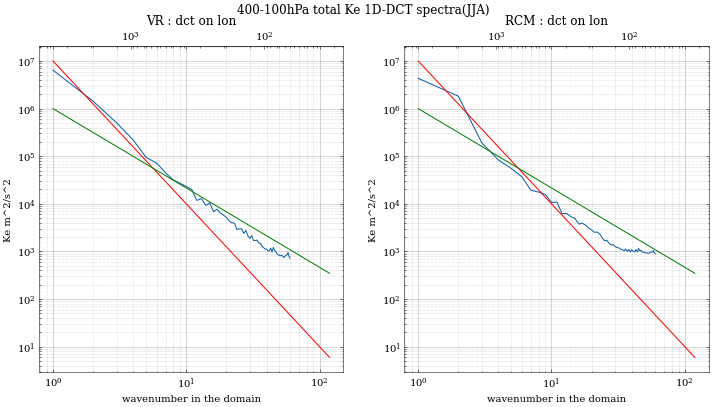

In [41]:
fig, axs = plt.subplots(1,2,figsize=(12, 6))
plt.style.use(['science', 'no-latex']) # 采用 安装的scinence绘图风格，matplotlib风格拓展

# 原始的DCT系数
# axs[0].plot(xf[:N//2], np.sqrt(variance_smooth['vr']))
axs[0].plot(xf[:N//2], np.sqrt(variance_1d_filter['vr']))
# add reference line 
yref_synop = xf ** (-3.) * 1e7
yref_meso  = xf ** (-5./3) * 1e6
axs[0].plot(xf, yref_synop,color='r')
axs[0].plot(xf, yref_meso,color='g')

# 计算平均、平滑后的DCT方差
axs[1].plot(xf[:N//2], np.sqrt(variance_1d_filter['rcm']))
# add reference line
yref_synop = xf ** (-3.) * 1e7
yref_meso  = xf ** (-5./3) * 1e6
axs[1].plot(xf, yref_synop,color='r')
axs[1].plot(xf, yref_meso,color='g')


def upper_xaxis(x):
    domain_lon_range = 3829. # km
    return domain_lon_range / x

def upper_xaxis_inv(x):
    domain_lon_range = 3839. # km
    return (1. / x )/ domain_lon_range 

for axs_ind in axs:
    axs_ind.set_yscale('log')
    axs_ind.set_xscale('log')
    axs_ind.secondary_xaxis('top', functions = (upper_xaxis, upper_xaxis_inv) )

    axs_ind.xaxis.grid(True, which="minor", linestyle = ":")
    axs_ind.xaxis.grid(True, which="major", linestyle = "-")
    axs_ind.yaxis.grid(True, which="minor", linestyle = ":")
    axs_ind.yaxis.grid(True, which="major", linestyle = "-")

    axs_ind.set_xlabel('wavenumber in the domain')
    axs_ind.set_ylabel('Ke m^2/s^2')
axs[0].set_title('VR : dct on lon')
axs[1].set_title('RCM : dct on lon')
# axs[0].legend()
# axs[1].set_xlim([1e-5,1e-4])
fig.suptitle("400-100hPa total Ke 1D-DCT spectra(JJA)")
